In [2]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset,
    SotabCVTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
    device = torch.device(2)

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=16,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='SOTAB',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/yongkang/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = args.task
    if args.small_tag != "":
        args.eval_test = True
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device(2)
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version="v0", use_attention_mask=True)
        


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 16, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 91, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "SOTAB", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": true, "small_tag": "semi1", "data_path": "/data/yongkang/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
SOTAB/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-semi1-bs16-ml64-ne1-do0.5


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/tmp/ipykernel_2093037/3060214680.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control o

Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
best_state_dict = torch.load("/data/yongkang/TU/Watchog/outputs/SOTAB/bert-base-uncased-fromscratch-comma-bs16-ml128-ne50-do0.5_fully_deduplicated_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)

/tmp/ipykernel_2093037/1786997412.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/yongkang/TU/Watchog/outputs/SOTAB/bert-base-uncased

<All keys matched successfully>

In [5]:
df = pd.read_csv('/data/yongkang/TU/SOTAB/comma_train_filter_sotab.csv')

In [6]:
df_group = df.groupby('table_id')
num_cols = []
num_cols_gt = []
for table_id, group in df_group:
    num_cols.append(len(group))
    num_cols_gt.append(len(group[group['label']>-1]))

In [ ]:
import seaborn as sns
print(min(num_cols), max(num_cols), np.mean(num_cols), np.median(num_cols))
sns.histplot(num_cols)

1 29 2.8656768255622125 2.0


<Axes: ylabel='Count'>

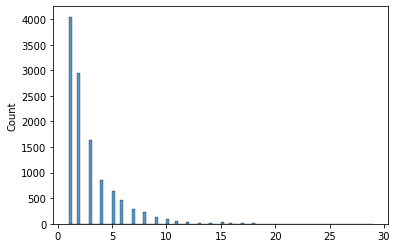

In [7]:
import seaborn as sns
print(min(num_cols_gt), max(num_cols_gt), np.mean(num_cols_gt), np.median(num_cols_gt))
sns.histplot(num_cols_gt)

In [5]:
def extract_cls_tokens(hidden_states, cls_indexes, head=False):
    cls_embeddings = []
    for i, j in cls_indexes:
        sub_sentence_cls_embeddings = hidden_states[i, 0, :] if head else hidden_states[i, j, :]
        cls_embeddings.append(sub_sentence_cls_embeddings)
    cls_embeddings = torch.stack(cls_embeddings)
    return cls_embeddings
#pooled_outputs = extract_cls_tokens(hidden_states, cls_indexes)

In [47]:
from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer
from typing import List
from functools import reduce
import operator
from sklearn.preprocessing import LabelEncoder
class SOTABTablewiseIterateDataset(data.Dataset):

    def __init__(
            self,
            # cv: int,
            split: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            # multicol_only: bool = False,
            train_ratio: float = 1.0,
            device: torch.device = None,
            base_dirpath: str = "/data/yongkang/TU/SOTAB",
            small_tag: str = "",
            label_encoder: LabelEncoder = None,
            max_unlabeled=8,
            random_sample=False, # TODO
            gt_only=True,
            ):
        # ?
        if device is None:
            device = torch.device('cpu')

        assert split in ["train", "valid", "test"]
        if split == "train":
            gt_df = pd.read_csv(os.path.join(base_dirpath, "CTA_training_small_gt.csv"))
            data_folder = "Train"
        elif split == "valid":
            gt_df = pd.read_csv(os.path.join(base_dirpath, "CTA_validation_gt.csv"))
            data_folder = "Validation"
        else:  # test
            gt_df = pd.read_csv(os.path.join(base_dirpath, "CTA_test_gt.csv"))
            data_folder = "Test"

        # 初始化或加载 LabelEncoder
        if label_encoder is None:
            label_encoder = LabelEncoder()
            label_encoder.fit(gt_df['label'])
        self.label_encoder = label_encoder

        # gt_set = set(zip(gt_df["table_name"], gt_df["column_index"]))

        table_files = [f for f in os.listdir(os.path.join(base_dirpath, data_folder)) if f in gt_df['table_name'].values]

        mapping_file_path = os.path.join(base_dirpath, "label_mapping.txt")
        df_csv_path = os.path.join(base_dirpath, f"comma_{split}_fully_deduplicated_sotab.csv")

        # 检查是否存在之前保存的标签映射关系
        if os.path.exists(mapping_file_path):
            # 如果存在，直接从文件中读取映射
            with open(mapping_file_path, 'r') as f:
                label_mapping = json.load(f)
            next_label_id = max(label_mapping.values()) + 1
            print(f"标签映射关系从 {mapping_file_path} 读取成功")
        else:
            raise FileNotFoundError(f"{mapping_file_path} 文件不存在，请确认文件路径")

        # 检查 CSV 文件是否存在
        if os.path.exists(df_csv_path):
            # 直接从 CSV 文件中读取数据
            df = pd.read_csv(df_csv_path)
            print(f"数据已从 {df_csv_path} 加载")
        else:
            raise FileNotFoundError(f"{df_csv_path} 文件不存在，请确认文件路径")
        
        if gt_only:
            df = df[df["label"] > -1]

        data_list = []

        df['label'] = df['label'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['label'] == -1)].index, inplace=True)
        df['column_index'] = df['column_index'].astype(int)
        df['data'] = df['data'].astype(str)

        print("start encoder")
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            # if split == "train" and ((i >= num_train) or (i >= valid_index)):
            #     break
            # if split == "valid" and i < valid_index:
            #     continue

            labeled_columns = group_df[group_df['label'] > -1]
            unlabeled_columns = group_df[group_df['label'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns))
            unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
            group_df = pd.concat([group_df[group_df['label'] > -1], unlabeled_columns]) # TODO
            group_df.sort_values(by=['column_index'], inplace=True)

            num_labels = len(list(group_df["label"].values))
            if max_length <= 128:
                cur_maxlen = min(max_length, 512 // num_labels - 1)
            else:
                cur_maxlen = max(1, max_length // num_labels - 1)

            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["label"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                new_token_ids_list = []
                for col_j in range(len(token_ids_list)):
                    if len(set(target_col_mask)) == max_unlabeled-1 and 0 not in target_col_mask and col_j != col_i:
                        # skip the rest of the columns until the target one
                        continue
                    
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                    new_token_ids_list.append(token_ids_list[col_j])
                    if len(set(target_col_mask)) == max_unlabeled and 0 in target_col_mask:
                        break
                new_token_ids_list = torch.LongTensor(reduce(operator.add,
                                                new_token_ids_list)).to(device)
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["label"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), new_token_ids_list, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [44]:
def collate_fn(pad_token_id, data_only=True):
    '''padder for input batch'''

    def padder(samples):    
        data = torch.nn.utils.rnn.pad_sequence(
            [sample["data"] for sample in samples], padding_value=pad_token_id)
        if not data_only:
            label = torch.nn.utils.rnn.pad_sequence(
                [sample["label"] for sample in samples], padding_value=-1)
        else:
            label = torch.cat([sample["label"] for sample in samples])
        batch = {"data": data, "label": label}
        if "idx" in samples[0]:
            batch["idx"] = [sample["idx"] for sample in samples]
        if "cls_indexes" in samples[0]:
            cls_indexes = torch.nn.utils.rnn.pad_sequence(
                [sample["cls_indexes"] for sample in samples], padding_value=0)
            batch["cls_indexes"] = cls_indexes
        if "target_col_mask" in samples[0]:
            target_col_mask = torch.nn.utils.rnn.pad_sequence(
                [sample["target_col_mask"] for sample in samples], padding_value=-1)
            batch["target_col_mask"] = target_col_mask
        if "table_embedding" in samples[0]:
            table_embeddings = [sample["table_embedding"] for sample in samples]
            batch["table_embedding"] = torch.stack(table_embeddings, dim=0)
        return batch
        
    return padder

In [28]:
src = None
max_unlabeled=8
test_dataset_iter = SOTABTablewiseIterateDataset(# cv=cv,
                                        split="test",
                                        tokenizer=tokenizer,
                                        max_length=max_length,
                                        # multicol_only=multicol_only,
                                        device=device,
                                        gt_only=False,
                                        base_dirpath=os.path.join(args.data_path, "SOTAB"),
                                        max_unlabeled=max_unlabeled
                                        )
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_test_fully_deduplicated_sotab.csv 加载
start encoder
test 15040


In [ ]:
num_cols_test = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)
    num_cols_test.append(len(init_permutation_i))
sns.histplot(num_cols_test)

In [48]:
src = None
max_unlabeled=8
valid_dataset_iter = SOTABTablewiseIterateDataset(# cv=cv,
                                            split="valid",
                                            tokenizer=tokenizer,
                                            max_length=max_length,
                                            # multicol_only=multicol_only,
                                            device=device,
                                            gt_only=False,
                                            base_dirpath=os.path.join(args.data_path, "SOTAB"),
                                            max_unlabeled=max_unlabeled
                                            )
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_iter = DataLoader(valid_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_valid_fully_deduplicated_sotab.csv 加载
start encoder
valid 16840


In [12]:
train_dataset_iter = SOTABTablewiseIterateDataset(
                            split="train", 
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only=False,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "SOTAB"))
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_iter = DataLoader(train_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_train_fully_deduplicated_sotab.csv 加载
start encoder
train 33004


In [23]:
# strict truncate max_num_cols
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
 
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.8701, ts_macro_f1=0.8594
ts_micro_f1=0.8701, ts_macro_f1=0.8594
ts_micro_f1=0.0000, ts_macro_f1=nan


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
# strict truncate max_num_cols
for max_num_cols in [4, 16]:
    print("=============================max_num_cols={}===============================".format(max_num_cols))
    src = None
    test_dataset_iter = SOTABTablewiseIterateDataset(# cv=cv,
                                            split="test",
                                            tokenizer=tokenizer,
                                            max_length=max_length,
                                            # multicol_only=multicol_only,
                                            device=device,
                                            gt_only=False,
                                            base_dirpath=os.path.join(args.data_path, "SOTAB"),
                                            max_unlabeled=max_num_cols
                                            )
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_iter = DataLoader(test_dataset_iter,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    
    
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(batch["target_col_mask"].max().item())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

=============================max_num_cols=4===============================
标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_test_fully_deduplicated_sotab.csv 加载
start encoder
test 15040
ts_micro_f1=0.7612, ts_macro_f1=0.7696
ts_micro_f1=0.7612, ts_macro_f1=0.7696
ts_micro_f1=0.0000, ts_macro_f1=nan
=============================max_num_cols=16===============================


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_test_fully_deduplicated_sotab.csv 加载
start encoder
test 15040
ts_micro_f1=0.8735, ts_macro_f1=0.8627
ts_micro_f1=0.8735, ts_macro_f1=0.8627
ts_micro_f1=0.0000, ts_macro_f1=nan


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [52]:
src = None
test_dataset_iter = SOTABTablewiseIterateDataset(# cv=cv,
                                        split="test",
                                        tokenizer=tokenizer,
                                        max_length=max_length,
                                        # multicol_only=multicol_only,
                                        device=device,
                                        gt_only=False,
                                        base_dirpath=os.path.join(args.data_path, "SOTAB"),
                                        max_unlabeled=8,
                                        )
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

标签映射关系从 /data/yongkang/TU/SOTAB/label_mapping.txt 读取成功
数据已从 /data/yongkang/TU/SOTAB/comma_test_fully_deduplicated_sotab.csv 加载
start encoder
test 15040


<Axes: ylabel='Count'>

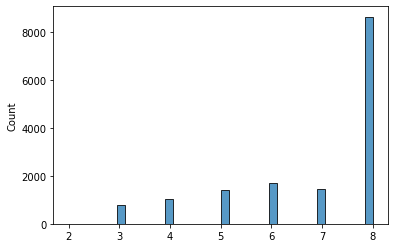

In [22]:
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import seaborn as sns
num_cols_test_truncate = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)
    num_cols_test_truncate.append(len(init_permutation_i))
sns.histplot(num_cols_test_truncate)




In [53]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
test_data = defaultdict(list)
test_logits = defaultdict(list)
test_cls_indexes = defaultdict(list)
test_target_col_mask = defaultdict(list)
test_embs = defaultdict(list)
test_col_num = defaultdict(list)
test_label = defaultdict(list)
test_class = defaultdict(list)
test_target_embs = defaultdict(list)
test_drop_idx = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 


ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
num_permutations = {}
init_permutation = {}
init_correctness = {}
score_init = {}
score_permutation = defaultdict(list)
permutation_correctness = defaultdict(list)
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0


        x = [0]
        new_batch_data = []
        for col_i in x:
            if col_i == 0:
                if len(new_batch_data) == 0:
                    cls_indexes_value = 0
                else:
                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
        test_target_embs[batch_idx].append(embs_temp.cpu())


        num_cols.append(len(init_permutation_i))
        labels_test.append(batch["label"].cpu())
        col_idx_set = target_col_mask.unique().tolist()
        assert -1 not in col_idx_set
        for r in range(len(init_permutation_i), 1, -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue

                num_permutations[batch_idx] += 1
                new_batch_data = []
                if len(x) != len(init_permutation_i):
                    drop_idx = (set(init_permutation_i)-set(x)).pop()
                else:
                    drop_idx = -1
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                score_permutation[batch_idx].append(ood_score_temp)
                predict_temp = logits_temp.argmax().item()
                permutation_correctness[batch_idx].append(predict_temp == label_i)
                
                test_data[batch_idx].append(new_batch_data.cpu())
                test_logits[batch_idx].append(logits_temp.detach().cpu())
                test_cls_indexes[batch_idx].append(cls_indexes_value)
                test_embs[batch_idx].append(embs_temp.cpu())
                test_col_num[batch_idx].append(len(x))
                test_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                test_class[batch_idx].append(label_i)
                test_drop_idx[batch_idx].append(drop_idx)
        if batch_idx % 1000 == 0:
            print(batch_idx, '/', len(valid_dataloader_iter))

*********************Threshold: 1.5****************************


/tmp/ipykernel_1560166/2479533116.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_1560166/2479533116.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


0 / 16840
1000 / 16840
2000 / 16840
3000 / 16840
4000 / 16840
5000 / 16840
6000 / 16840
7000 / 16840
8000 / 16840
9000 / 16840
10000 / 16840
11000 / 16840
12000 / 16840
13000 / 16840
14000 / 16840
15000 / 16840


In [54]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
            "embs": test_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data.pth")

In [26]:
# check test data
labels_test = []
logits_test = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    embs = test_embs[batch_idx][0].reshape(1,-1)
    logits = test_logits[batch_idx][0].reshape(-1)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.8781, ts_macro_f1=0.8657


In [55]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
veri_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 


ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
num_permutations = {}
init_permutation = {}
init_correctness = {}
score_init = {}
score_permutation = defaultdict(list)
permutation_correctness = defaultdict(list)
with torch.no_grad():
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0

        x = [0]
        new_batch_data = []
        for col_i in x:
            if col_i == 0:
                if len(new_batch_data) == 0:
                    cls_indexes_value = 0
                else:
                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
        veri_target_embs[batch_idx].append(embs_temp.cpu())

        num_cols.append(len(init_permutation_i))
        labels_test.append(batch["label"].cpu().item())
        col_idx_set = target_col_mask.unique().tolist()
        assert -1 not in col_idx_set
        for r in range(len(init_permutation_i), 0, -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue

                num_permutations[batch_idx] += 1
                new_batch_data = []
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                score_permutation[batch_idx].append(ood_score_temp)
                predict_temp = logits_temp.argmax().item()
                permutation_correctness[batch_idx].append(predict_temp == label_i)
                
                
                if predict_temp == label_i and r < max(len(init_permutation_i)-2, len(init_permutation_i)//2):
                    continue
                veri_data[batch_idx].append(new_batch_data.cpu())
                veri_logits[batch_idx].append(logits_temp.detach().cpu())
                veri_cls_indexes[batch_idx].append(cls_indexes_value)
                veri_embs[batch_idx].append(embs_temp.cpu())
                veri_col_num[batch_idx].append(len(x))
                veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                veri_class[batch_idx].append(label_i)

        if batch_idx % 1000 == 0:
            print(batch_idx, '/', len(valid_dataloader_iter))
                    # if predict_temp == label_i and r < max(len(init_permutation_i)-2, len(init_permutation_i)//2):
                    #     continue

*********************Threshold: 1.5****************************


/tmp/ipykernel_1560166/1950327127.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_1560166/1950327127.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


0 / 16840
1000 / 16840
2000 / 16840
3000 / 16840
4000 / 16840
5000 / 16840
6000 / 16840
7000 / 16840
8000 / 16840
9000 / 16840
10000 / 16840
11000 / 16840
12000 / 16840
13000 / 16840
14000 / 16840
15000 / 16840
16000 / 16840


In [57]:
import os
# SOTAB, col num from 8 to 1, all negs, half pos
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs , "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data.pth")